In [22]:
import os
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import cv2
from PIL import Image
import secrets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
! pip install torchsummary

In [4]:
! pip install opencv-python

In [5]:
# Define paths for dataset and model
base_path = "C:/Users/kimaa/OneDrive/Desktop"

data_path = os.path.join(base_path, "imgs", "train")
model_dir = os.path.join(base_path, "model", "simple_cnn")

os.makedirs(model_dir, exist_ok=True)

print("Data Directory:", data_path)
print("Model Directory:", model_dir)


Data Directory: C:/Users/kimaa/OneDrive/Desktop\imgs\train
Model Directory: C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn


In [6]:
if os.path.exists(data_path):
    print("Directory exists. Contents:", os.listdir(data_path))
else:
    print("Directory does not exist. Check the path.")

Directory exists. Contents: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [7]:
# Preprocessing functions for the images
def enhance_brightness(img, value_increment):
    hsv_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_img)
    v = cv2.add(v, value_increment)
    final_hsv = cv2.merge((h, s, v))
    return Image.fromarray(cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB))

def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    return img.point(lambda c: 128 + factor * (c - 128))

class RandomContrastBrightnessTransform:
    def __call__(self, img):
        if secrets.randbelow(2) == 0:
            img = enhance_brightness(img, secrets.randbelow(26))
            img = change_contrast(img, secrets.randbelow(51))
        else:
            img = change_contrast(img, secrets.randbelow(51))
            img = enhance_brightness(img, secrets.randbelow(26))
        return img


In [8]:
# Image transformations
transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.02, 0.02), shear=0.01, scale=(0.95, 1.05)),
    RandomContrastBrightnessTransform(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [9]:
# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

In [10]:
# Split the dataset into training and validation sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)  # e.g., 80% for training
test_size = total_size - train_size  # 20% for validation

In [11]:
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [12]:
# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [13]:
# Fetch one batch of data
images, labels = next(iter(train_loader))

# Print the shape of the images tensor
print("Shape of images in a batch:", images.shape)

Shape of images in a batch: torch.Size([128, 3, 224, 224])


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust the input features correctly based on the output from the last pooling layer
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Apply conv1
        x = self.pool1(self.act1(self.conv1(x)))
        # Apply conv2
        x = self.pool2(self.act2(self.conv2(x)))
        # Apply conv3
        x = self.pool3(self.act3(self.conv3(x)))
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 128 * 28 * 28)  # Flatten to match the fully connected layer's input size
        
        # Apply fc1
        x = F.relu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleCNN(num_classes=10)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [15]:
# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Checkpoint and Early Stopping Setup
def save_checkpoint(model, epoch, val_accuracy):
    filename = f"model_simplecnn-{epoch:02d}-{val_accuracy:.2f}.pt"
    path = os.path.join(model_dir, filename)
    torch.save(model.state_dict(), path)
    print(f"Checkpoint saved to {path}")

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [17]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    early_stopping = EarlyStopping(patience=5, verbose=True)
    
    # Lists to store metrics for plotting
    train_losses, test_losses = [], []
    test_accuracies = []

    #start_time = datetime.now()
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for data, targets in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}', leave=False):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * data.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        correct = 0
        for data, targets in tqdm(test_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}', leave=False):
            with torch.no_grad():
                outputs = model(data)
                loss = criterion(outputs, targets)
                total_test_loss += loss.item() * data.size(0)
                predictions = outputs.argmax(dim=1, keepdim=True)
                correct += predictions.eq(targets.view_as(predictions)).sum().item()

        avg_test_loss = total_test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
        test_accuracy = correct / len(test_loader.dataset)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

        # Save checkpoint if test accuracy has improved
        save_checkpoint(model, epoch+1, test_accuracy)

        # Check for early stopping condition
        early_stopping(avg_test_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    #end_time = datetime.now()
    #print('Training completed in:', end_time - start_time)
    
    return train_losses, test_losses, test_accuracies


In [18]:
start_time = datetime.now()
train_losses, test_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)


Epoch 1: Train Loss: 1.7206, Test Loss: 1.0334, Test Accuracy: 0.64
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-01-0.64.pt


Epoch 2: Train Loss: 0.6168, Test Loss: 0.4811, Test Accuracy: 0.84
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-02-0.84.pt


Epoch 3: Train Loss: 0.3243, Test Loss: 0.2342, Test Accuracy: 0.93
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-03-0.93.pt


Epoch 4: Train Loss: 0.2037, Test Loss: 0.2040, Test Accuracy: 0.93
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-04-0.93.pt


Epoch 5: Train Loss: 0.1463, Test Loss: 0.1460, Test Accuracy: 0.95
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-05-0.95.pt


Epoch 6: Train Loss: 0.1248, Test Loss: 0.1303, Test Accuracy: 0.96
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-06-0.96.pt


Epoch 7: Train Loss: 0.1009, Test Loss: 0.0846, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-07-0.98.pt


Epoch 8: Train Loss: 0.0867, Test Loss: 0.1165, Test Accuracy: 0.97
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-08-0.97.pt
EarlyStopping counter: 1 out of 5


Epoch 9: Train Loss: 0.0756, Test Loss: 0.0976, Test Accuracy: 0.97
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-09-0.97.pt
EarlyStopping counter: 2 out of 5


Epoch 10: Train Loss: 0.0748, Test Loss: 0.0901, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-10-0.98.pt
EarlyStopping counter: 3 out of 5


Epoch 11: Train Loss: 0.0566, Test Loss: 0.0981, Test Accuracy: 0.97
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-11-0.97.pt
EarlyStopping counter: 4 out of 5


Epoch 12: Train Loss: 0.0560, Test Loss: 0.0765, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-12-0.98.pt


Epoch 13: Train Loss: 0.0476, Test Loss: 0.0653, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-13-0.98.pt


Epoch 14: Train Loss: 0.0480, Test Loss: 0.0592, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-14-0.98.pt


Epoch 15: Train Loss: 0.0400, Test Loss: 0.0851, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-15-0.98.pt
EarlyStopping counter: 1 out of 5


Epoch 16: Train Loss: 0.0422, Test Loss: 0.0575, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-16-0.98.pt


Epoch 17: Train Loss: 0.0384, Test Loss: 0.0551, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-17-0.98.pt


Epoch 18: Train Loss: 0.0359, Test Loss: 0.0620, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-18-0.98.pt
EarlyStopping counter: 1 out of 5


Epoch 19: Train Loss: 0.0352, Test Loss: 0.0949, Test Accuracy: 0.97
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-19-0.97.pt
EarlyStopping counter: 2 out of 5


Epoch 20: Train Loss: 0.0363, Test Loss: 0.0593, Test Accuracy: 0.98
Checkpoint saved to C:/Users/kimaa/OneDrive/Desktop\model\simple_cnn\model_simplecnn-20-0.98.pt
EarlyStopping counter: 3 out of 5


In [19]:
end_time = datetime.now()
print('Training completed in:', end_time - start_time)

Training completed in: 3:41:50.964446


In [25]:
# After running the training loop
final_highest_test_accuracy = max(test_accuracies)
print("Best test accuracy:", final_highest_test_accuracy)


Best test accuracy: 0.9841694537346711


In [20]:
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

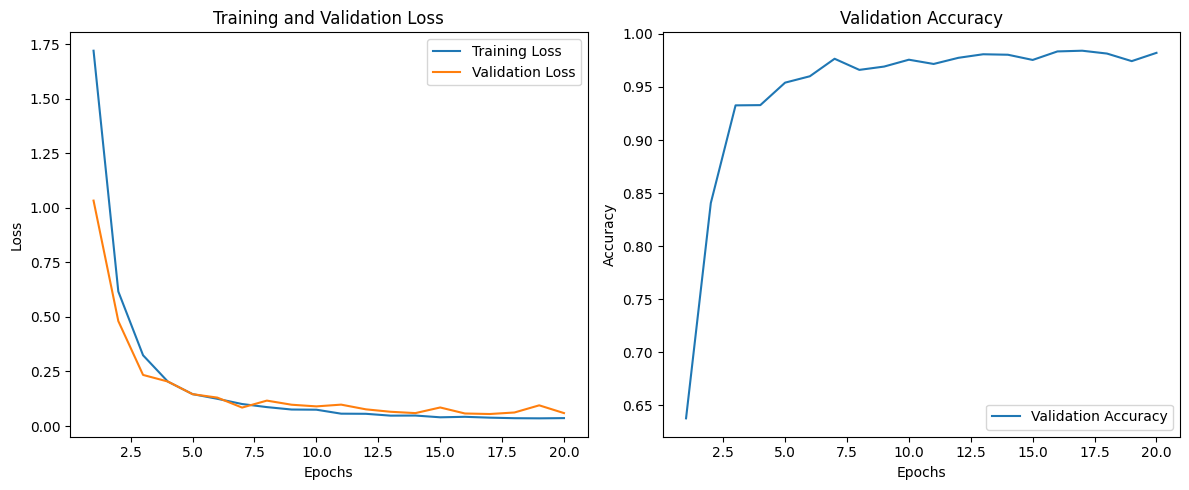

In [23]:
plot_metrics(train_losses, test_losses, test_accuracies)